In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-3.0.1-bin-hadoop2.7'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from plotnine import *
import matplotlib.pyplot as plt
import pandas
import numpy as np

In [3]:
spark = SparkSession.builder.appName('cs5488project').getOrCreate()
injury = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/InjuryRecord.csv",header=True,inferSchema=True)
playlist = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayList.csv",header=True,inferSchema=True)
playtrack = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayerTrackData.csv",header=True,inferSchema=True)

injury.printSchema()
playlist.printSchema()
#playtrack.printSchema()

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- BodyPart: string (nullable = true)
 |-- Surface: string (nullable = true)
 |-- DM_M1: integer (nullable = true)
 |-- DM_M7: integer (nullable = true)
 |-- DM_M28: integer (nullable = true)
 |-- DM_M42: integer (nullable = true)

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- RosterPosition: string (nullable = true)
 |-- PlayerDay: integer (nullable = true)
 |-- PlayerGame: integer (nullable = true)
 |-- StadiumType: string (nullable = true)
 |-- FieldType: string (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Weather: string (nullable = true)
 |-- PlayType: string (nullable = true)
 |-- PlayerGamePlay: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- PositionGroup: string (nullable = true)



In [14]:
injury.groupBy('Surface').count().show()

+---------+-----+
|  Surface|count|
+---------+-----+
|Synthetic|   57|
|  Natural|   48|
+---------+-----+



In [15]:
playlist.groupBy('PlayType').count().show()

+--------------------+------+
|            PlayType| count|
+--------------------+------+
|             Kickoff|  5754|
|         Extra Point|  5906|
|Kickoff Not Returned|  4625|
|                   0|   279|
|                null|   367|
|   Punt Not Returned|  3486|
|          Field Goal|  4915|
|       Punt Returned|  2469|
|                Rush| 92606|
|    Kickoff Returned|  2773|
|                Punt|  5746|
|                Pass|138079|
+--------------------+------+



In [19]:
injury = injury.withColumn("Severity", col("DM_M1") + col("DM_M7") + col("DM_M28") + col("DM_M42"))
injury = injury.withColumn("SevLevel", when(col("Severity") >=3, "H").otherwise("L"))
injury = injury.select("PlayerKey","GameID","PlayKey","BodyPart","Surface","Severity","SevLevel")

In [20]:
# 1, injury count by surface, severity -- a slightly higher rate for severe injury (missed day > 28 (DM_28 / DM_42)) for synthetic surface
severity = injury.groupBy('Severity', 'Surface').count().orderBy(col("Severity").asc(), col('Surface').desc())

In [21]:
severity.show()

+--------+---------+-----+
|Severity|  Surface|count|
+--------+---------+-----+
|       1|Synthetic|   16|
|       1|  Natural|   13|
|       2|Synthetic|   19|
|       2|  Natural|   20|
|       3|Synthetic|    6|
|       3|  Natural|    2|
|       4|Synthetic|   16|
|       4|  Natural|   13|
+--------+---------+-----+



In [22]:
p1 = ggplot(severity.toPandas(), aes(x='Severity', y="count", color="Surface", fill="Surface")) + \
    geom_bar(stat="identity", width=0.5, position='dodge') + \
    labs(x="Severity", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 25, 2))

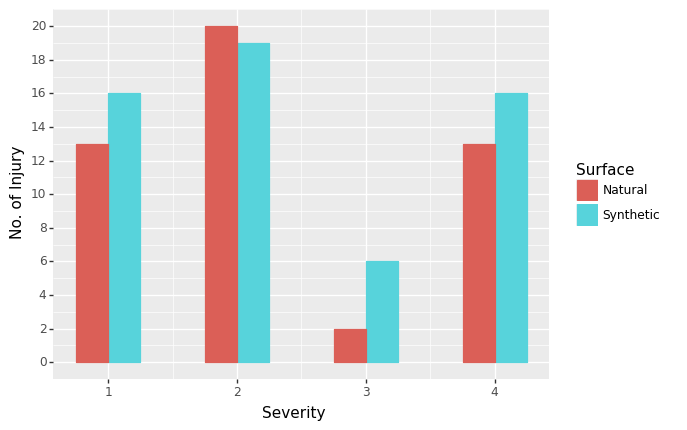

<ggplot: (147729307149)>

In [23]:
p1

In [24]:
sevLevel = injury.groupBy('SevLevel', 'Surface').count().orderBy(col("SevLevel").asc(), col('Surface').desc())

In [25]:
sevLevel.show()

+--------+---------+-----+
|SevLevel|  Surface|count|
+--------+---------+-----+
|       H|Synthetic|   22|
|       H|  Natural|   15|
|       L|Synthetic|   35|
|       L|  Natural|   33|
+--------+---------+-----+



In [26]:
p2 = ggplot(sevLevel.toPandas(), aes(x='SevLevel', y='count', color="Surface", fill="Surface")) + \
    geom_bar(stat="identity", width=0.2, position='dodge') +\
    labs(x="Severity Level", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 40, 5))

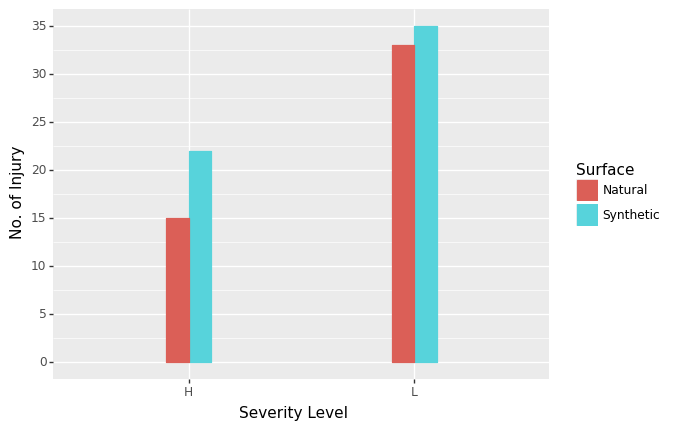

<ggplot: (147731697424)>

In [27]:
p2

In [28]:
# 2, injury count by body part, severity, surface 
# -- analyse by body part: ankle shows more severe injury on synthetic surface, knee and toes injury do not show significant difference on both surfaces
# -- surprisingly, foot has more severe injury reported on natural surface  
sevBodyPart = injury.groupBy('BodyPart', 'Severity','Surface').count().orderBy(col('BodyPart').asc(), col('Severity').desc(),col('Surface').asc())

In [29]:
sevBodyPart.show()

+--------+--------+---------+-----+
|BodyPart|Severity|  Surface|count|
+--------+--------+---------+-----+
|   Ankle|       4|  Natural|    3|
|   Ankle|       4|Synthetic|    8|
|   Ankle|       3|Synthetic|    2|
|   Ankle|       2|  Natural|    6|
|   Ankle|       2|Synthetic|    7|
|   Ankle|       1|  Natural|    8|
|   Ankle|       1|Synthetic|    8|
|    Foot|       4|  Natural|    4|
|    Foot|       4|Synthetic|    1|
|    Foot|       3|  Natural|    1|
|    Foot|       3|Synthetic|    1|
|    Heel|       2|  Natural|    1|
|    Knee|       4|  Natural|    6|
|    Knee|       4|Synthetic|    7|
|    Knee|       3|  Natural|    1|
|    Knee|       3|Synthetic|    2|
|    Knee|       2|  Natural|   12|
|    Knee|       2|Synthetic|    9|
|    Knee|       1|  Natural|    5|
|    Knee|       1|Synthetic|    6|
+--------+--------+---------+-----+
only showing top 20 rows



In [30]:
p3 = ggplot(sevBodyPart.toPandas(), aes(x='Severity', y="count", color="BodyPart", fill="BodyPart")) + \
    geom_bar(stat="identity", width=0.5) + \
    facet_grid('Surface ~ BodyPart') + \
    labs(x="Severity", y='No. of Injury') +  theme_bw() +  theme(axis_text_x = element_text(angle = 270, hjust = 1), panel_grid_major = element_line(colour = "white"), strip_background = element_rect(colour = "white", fill="white")) + \
    scale_y_continuous(breaks=np.arange(0, 12, 2))

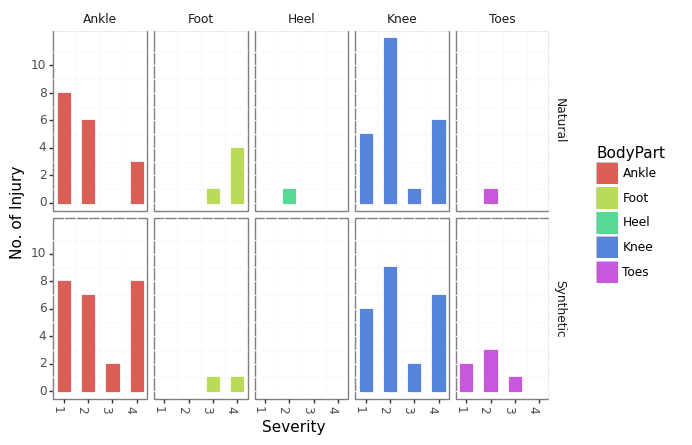

<ggplot: (147731813581)>

In [31]:
p3

In [32]:
# 3, injury count by roster position, severity, surface 
# -- the percentage of record without roster position is significant in this dataset, the data are too scattered
# -- no observation can be made
#detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey, 'left')
detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey)
#sevRosterPos = detail.groupBy('Surface','Severity','RosterPosition').count().orderBy(col('Severity').asc(), col('RosterPosition').asc())
sevRosterPos = detail.groupBy('Surface','RosterPosition','Severity').count().orderBy(col('RosterPosition').asc(), col('Severity').desc())

In [33]:
p4 = ggplot(sevRosterPos.toPandas(), aes(x='Severity', y="count",color='RosterPosition',fill='RosterPosition')) + \
    geom_bar(stat="identity", width=0.8, position='dodge') + \
    facet_grid('Surface ~ ') + \
    labs(x="Severity", y='No. of Injury')

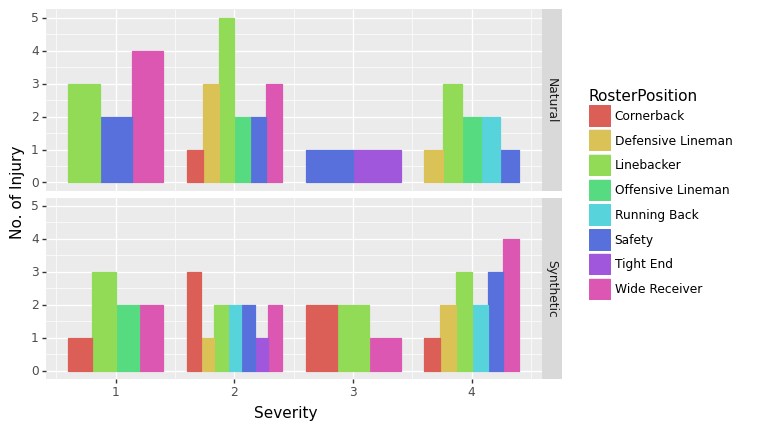

<ggplot: (147733175381)>

In [34]:
p4

In [35]:
pY = ggplot(sevRosterPos.toPandas(), aes(x='RosterPosition', y="count",color='Severity',fill='Severity')) + \
    geom_col(stat="identity", width=0.8) + \
    facet_grid('Surface ~ ') + \
    labs(x="RosterPosition", y='No. of Injury') + theme_bw() + theme(axis_text_x = element_text(angle = 270, hjust = 1), panel_grid_major = element_line(colour = "white"), strip_background = element_rect(colour = "white", fill="white")) + \
    scale_y_continuous(breaks=np.arange(0, 12, 2)) 
    

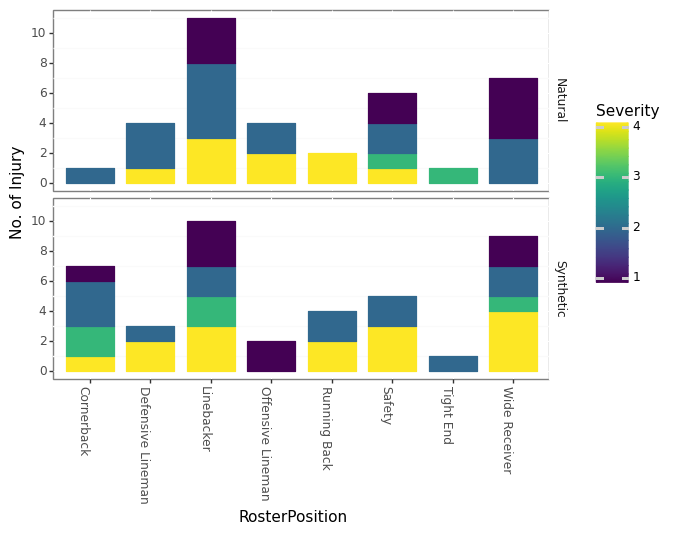

<ggplot: (147733157133)>

In [36]:
pY

In [37]:
# 3, injury count by roster position, severity, surface 
# -- the percentage of record without roster position is significant in this dataset, the data are too scattered
# -- no observation can be made
#detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey, 'left')
detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey)
#sevRosterPos = detail.groupBy('Surface','Severity','RosterPosition').count().orderBy(col('Severity').asc(), col('RosterPosition').asc())
sevPlayerPos = detail.groupBy('Surface','Position','Severity').count().orderBy(col('Position').asc(), col('Severity').desc())

In [38]:
detail.select('Position', 'PositionGroup').distinct().collect()

[Row(Position='DE', PositionGroup='DL'),
 Row(Position='LB', PositionGroup='LB'),
 Row(Position='OLB', PositionGroup='LB'),
 Row(Position='C', PositionGroup='OL'),
 Row(Position='DB', PositionGroup='DB'),
 Row(Position='DT', PositionGroup='DL'),
 Row(Position='SS', PositionGroup='DB'),
 Row(Position='T', PositionGroup='OL'),
 Row(Position='WR', PositionGroup='WR'),
 Row(Position='TE', PositionGroup='TE'),
 Row(Position='ILB', PositionGroup='LB'),
 Row(Position='MLB', PositionGroup='LB'),
 Row(Position='CB', PositionGroup='DB'),
 Row(Position='FS', PositionGroup='DB'),
 Row(Position='RB', PositionGroup='RB')]

In [39]:
p5 = ggplot(sevPlayerPos.toPandas(), aes(x='Severity', y="count",color='Position',fill='Position')) + \
    geom_bar(stat="identity", width=0.8, position='dodge') + \
    facet_grid('Surface ~ ') + \
    labs(x="Severity", y='No. of Injury')

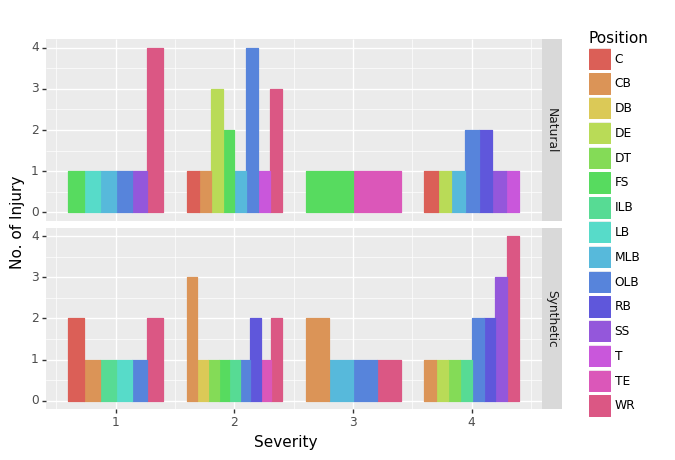

<ggplot: (147731556289)>

In [40]:
p5

In [41]:
pZ = ggplot(sevPlayerPos.toPandas(), aes(x='Position', y="count",color='Severity',fill='Severity')) + \
    geom_col(stat="identity", width=0.8) + \
    facet_grid('Surface ~ ') + \
    labs(x="Position", y='No. of Injury') + theme(axis_text_x = element_text(angle = 270, hjust = 1)) + \
    scale_y_continuous(breaks=np.arange(0, 12, 2))

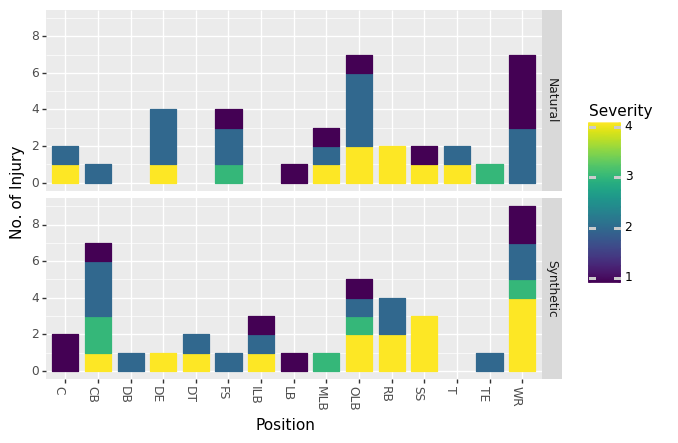

<ggplot: (147731859932)>

In [42]:
pZ

In [43]:
#detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey, 'left')
detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey)
detail.select("Surface","Severity","SevLevel", "Weather", "StadiumType" , "FieldType").show(100)
injAna = detail.groupBy('Surface','StadiumType','Weather').count().orderBy(col('Surface').asc(), col('StadiumType').asc(), col('Weather').asc())

+---------+--------+--------+--------------------+-------------------+---------+
|  Surface|Severity|SevLevel|             Weather|        StadiumType|FieldType|
+---------+--------+--------+--------------------+-------------------+---------+
|  Natural|       4|       H|               Sunny|            Outdoor|  Natural|
|  Natural|       3|       H|       Partly Cloudy|           Outdoors|  Natural|
|  Natural|       3|       H|       Partly Cloudy|            Outdoor|  Natural|
|  Natural|       2|       L|       Partly Cloudy|             Oudoor|  Natural|
|  Natural|       2|       L|               Clear|            Outdoor|  Natural|
|Synthetic|       2|       L|  Controlled Climate|            Indoors|Synthetic|
|Synthetic|       4|       H|      Clear and warm|            Outdoor|Synthetic|
|  Natural|       2|       L|                Rain|            Outdoor|  Natural|
|Synthetic|       4|       H|         Clear skies|             Indoor|Synthetic|
|  Natural|       4|       H

In [ ]:
#Data Cleansing

In [ ]:
#Stadium Type

In [44]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

In [45]:
closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 
                 'Indoor, Roof Closed', 'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',
                 'Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']

open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open','Domed, open', 'Domed, Open']

outdoor = ['Outdoors', 'Outdoor', 'Outdor', 'Ourdoor', 'Outddors', 'Outdoor Retr Roof-Open', 'Oudoor', 'Outside', 'Cloudy', 'Heinz Field', 'Bowl']



In [46]:
def convert_stadium(p):   
    if(p in closed):
        out = "Closed"
    elif(p in open):
        out = "Open"
    elif(p in outdoor):
        out = "Outdoor"
    else:
        out = "Unknown"
    return out

udf_convert_stadium = udf(convert_stadium, StringType())

In [47]:
rainy = ['30% Chance of Rain', 'Rainy', 'Rain Chance 40%', 'Showers', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain', 'Heavy lake effect snow', 'Snow']

cloudy = ['Party Cloudy', 'Cloudy, chance of rain','Coudy', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
            'Partly Clouidy', 'Mostly Coudy', 'Cloudy and Cool','cloudy', 'Partly cloudy', 'Overcast', 
            'Hazy', 'Mostly cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy','Cloudy, light snow accumulating 1-3"']

sunny = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny', 'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold', 'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny', 'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']

none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']


In [ ]:
#Weather

In [48]:
def convert_weather(p): 
  print(p)
  if(p in rainy):
    out = "Rainy"
  elif(p in cloudy):
    out = "Cloudy"
  elif(p in clear):
    out = "Sunny"
  elif(p in none):
   out =  "Unknown"
  else :
    out = "Unknown"
  return out

udf_convert_weather = udf(convert_weather, StringType())

In [49]:
injAna = injAna.withColumn('WeatherGrp', udf_convert_weather(injAna.Weather)) \
.withColumn('StadiumGrp', udf_convert_stadium(injAna.StadiumType))

In [51]:
Bad = ['30% Chance of Rain', 'Rainy', 'Rain Chance 40%', 'Showers', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
        'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain', 'Heavy lake effect snow', 'Snow','10% Chance of Rain']

Normal = ['Party Cloudy', 'Cloudy, chance of rain','Coudy', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
          'Partly Clouidy', 'Mostly Coudy', 'Cloudy and Cool','cloudy', 'Partly cloudy', 'Overcast', 
          'Hazy', 'Mostly cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Cloudy','Cloudy, light snow accumulating 1-3""','Controlled Climate']

Good = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny', 'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
        'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold', 'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
        'Clear Skies', 'Clear skies', 'Partly sunny', 'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny' ,'Clear to Partly Cloudy','Sunny, Windy']

none= ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)','Indoor,','T: 51; H: 55; W: NW 10 mph','Heat Index 95','NONE','N/A','null','None']

def convert_weather(p): 
  print(p)
  if(p in Bad):
    out = "Bad"
  elif(p in Normal):
    out = "Normal"
  elif(p in Good):
    out = "Good"
  elif(p in none):
   out =  "none"
  else :
    out = "Unknown"
  return out

udf_convert_weather = udf(convert_weather, StringType())

In [52]:
injAna = injAna.withColumn('WeatherGrp', udf_convert_weather(injAna.Weather)) \
.withColumn('StadiumGrp', udf_convert_stadium(injAna.StadiumType))

In [53]:
injAna.show(50)

+---------+-------------------+--------------------+-----+----------+----------+
|  Surface|        StadiumType|             Weather|count|WeatherGrp|StadiumGrp|
+---------+-------------------+--------------------+-----+----------+----------+
|  Natural|               Dome|                null|    1|   Unknown|    Closed|
|  Natural|               Open|       Partly Cloudy|    1|    Normal|      Open|
|  Natural|             Oudoor|       Partly Cloudy|    1|    Normal|      Open|
|  Natural|           Outddors|               Sunny|    2|      Good|      Open|
|  Natural|            Outdoor|               Clear|    4|      Good|      Open|
|  Natural|            Outdoor|              Cloudy|    6|    Normal|      Open|
|  Natural|            Outdoor|Cloudy with perio...|    1|       Bad|      Open|
|  Natural|            Outdoor|                Cold|    3|      Good|      Open|
|  Natural|            Outdoor|                Fair|    1|      Good|      Open|
|  Natural|            Outdo

In [ ]:
p5 = ggplot(injAna.toPandas(), aes(x='WeatherGrp', y="count",color='StadiumGrp',fill='StadiumGrp')) + \
    geom_bar(stat="identity", width=0.5) + \
    labs(x="WeatherGrp", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 30, 2))

In [ ]:
p5

In [ ]:
p6 = ggplot(injAna.toPandas(), aes(x='Severity', y="count",color='WeatherGrp',fill='WeatherGrp')) + \
    geom_bar(stat="identity", width=0.5) + \
    facet_grid('Surface ~ WeatherGrp') + \
    labs(x="Severity", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 15, 2))


In [ ]:
p6

In [ ]:
spark.stop()